In [141]:
'''
MCMC esimtate of Ne from simulated coal tree
from CTreeAnalysis (github)
Jose Manuel Agüero Trejo
Modified using Bio.Phylo
Also, getting coal intervals using node depths instead of heights
'''
import numpy
import math
from scipy.stats import lognorm
import matplotlib.pyplot as plt
from Bio import Phylo
import numpy as np

# height: distance to tip
# depth: distance to root
#max_height = 502
def internal_nodes_heights(node,nodes_heights, depth):
    if not node.is_terminal():
#        if node.name != 'root':
#        depth_to_root = list(node.depths().values())[0]
#        height = total_height - depth_to_root
#        print(node.name + "\t" + str(depth[node]))
#        nodes_heights.append(list(node.depths().values())[0])
        nodes_heights.append(depth[node])
        for child in node: # direct subclades
            internal_nodes_heights(child,nodes_heights, depth)

def mcmc(tree, max_steps, chain):
#    global dict_depth
#    sub_tree = tree.
    dict_depth = tree.depths()
    tmrc_depth = tree.branch_length
    for node in dict_depth:
        dict_depth[node] -= tmrc_depth
    ne = 100
    #generate list of times with k linages
    time_linage = list()
    time_interval = list()
    internal_nodes_heights(tree.root,time_linage, dict_depth) 
#    print(time_linage)
    time_linage.append(0)
    time_linage.sort()
#    print(time_linage)
    time_interval.append(0)
#    print(time_interval)
    for i in range(1,len(time_linage)):
#        print(i, end="\t")
#        print(time_linage[i-1], end="\t")
#        print(time_linage[i])
#        time_linage[i] = time_linage[i] - time_linage[i-1] # waiting time between coal events, exponential
        time_interval.append(time_linage[i] - time_linage[i-1]) # waiting time between coal events, exponential
    del time_interval[0]
#    del time_linage[-1]
#    time_interval.reverse()
#    time_interval.reverse()
#    print(time_interval)
    for i in range(max_steps):
        u = np.random.uniform(-10,10) #random step
        ne2 = ne + u
        if(ne2 > 0): #handle by rejectioon
            likelihood1 = 0
            likelihood2 = 0
            #generate log of the prior probability densities
            prior1 = lognorm.logpdf(ne, s = 1.25,scale=np.exp(3)) 
            prior2 = lognorm.logpdf(ne2, s = 1.25,scale=np.exp(3)) 
            for k in range(2,len(tree.get_terminals())):  #time interval with k linages
                tk = time_interval[k-2]
                b = (k*(k-1)*tk)/(2*ne)
                c = (k*(k-1)*tk)/(2*ne2)
                #compute the coalescent likelihood
                likelihood1 += (-np.log(ne) - b) 
                likelihood2 += (-np.log(ne2) - c)
            #obtain posterior distributions
            post1 = likelihood1 + (prior1) 
            post2 = likelihood2 + (prior2)
            post = post2 - post1
            #compute acceptance probability
            if post > -800 and post < 700: #handle overflow by reject large values
                a = min(1,np.exp(post))
                v = np.random.uniform(0,1)
                if(a > v):
                    ne = ne2
        chain.append(ne) #add to MCMC chain

#chain = list()
chain1 = list() 
chain2 = list() 
chain3 = list() 

#tree1 = Phylo.read("../cov2/wright-fisher-sim/neut.dnd", "newick")
tree1 = Phylo.read("../cov2/wright-fisher-sim/test-p200-g500-run-1st/neut.dnd", "newick")
tree2 = Phylo.read("../cov2/wright-fisher-sim/test-p200-g500-run-1st/bkg.dnd", "newick")
tree3 = Phylo.read("../cov2/wright-fisher-sim/test-p200-g500-run-1st/adpt.dnd", "newick")

# getting subtrees
tmrc_nodes1 = tree1.find_clades('co_1')
tmrc1 = next(tmrc_nodes1)
tmrc_nodes2 = tree2.find_clades('co_1')
tmrc2 = next(tmrc_nodes2)
tmrc_nodes3 = tree3.find_clades('co_1')
tmrc3 = next(tmrc_nodes3)

#Phylo.draw_ascii(tree3)
max_steps = 10000
#tmrc_nodes = tree.find_clades('co_1')
#tmrc = next(tmrc_nodes)
#print(tmrc.branch_length)
#tmrc = tmrc_nodes[0]
#dict_height = tmrc.depths()
#print(dict_height)
#dict_depth1 = tree1.depths()
#dict_depth2 = tree1.depths()
#dict_depth3 = tree1.depths()

#dict_height = {}
#for node in dict_depth:
#    dict_height[node] = max_height - dict_depth[node]
#print(dict_height)
#for node in dict_depth:
#    print(node, end = "\t")
#    print(dict_depth[node], end = "\t")
#    print(max_height - dict_depth[node])
#mcmc(tree,max_steps,chain) #generate MCMC chain
#print(tree.depths())
#plot histograms

#tree2 = Phylo.read("../cov2/wright-fisher-sim/bkg.dnd", "newick")
#tree3 = Phylo.read("../cov2/wright-fisher-sim/adpt.dnd", "newick")

# run mcmc
priors = np.random.lognormal(3,1.25,10000)
mcmc(tmrc, max_steps, chain) #generate MCMC chain
mcmc(tmrc1, max_steps, chain1) #generate MCMC chain
mcmc(tmrc2, max_steps, chain2) #generate MCMC chain
mcmc(tmrc3, max_steps, chain3) #generate MCMC chain


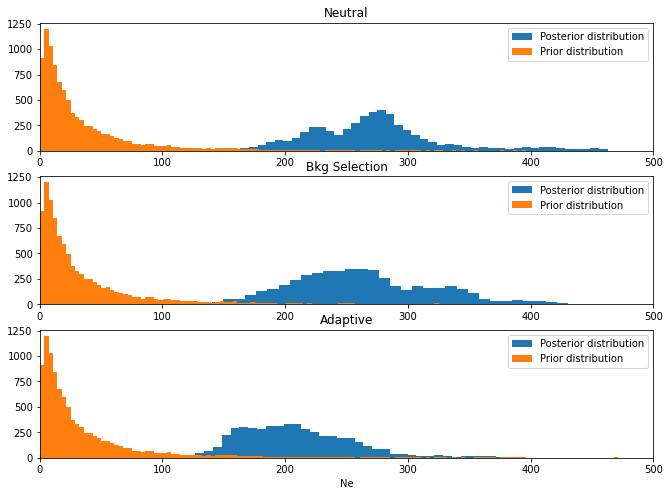

In [148]:
# make plots
fig, axs = plt.subplots(3)

plt.xlabel("Ne")
axs[0].set_xlim(0, 500)
axs[1].set_xlim(0, 500)
axs[2].set_xlim(0, 500)


axs[0].set_title('Neutral')
axs[1].set_title('Bkg Selection')
axs[2].set_title('Adaptive')
    
axs[0].hist(chain1[5000:], label = "Posterior distribution",bins = "auto")
axs[0].hist(priors, label = "Prior distribution",bins = "auto")
#axs[0].vlines(200, 0, 1250)
axs[0].legend(loc = 'upper right')

axs[1].hist(chain2[5000:], label = "Posterior distribution",bins = "auto")
axs[1].hist(priors, label = "Prior distribution",bins = "auto")
#axs[1].vlines(200, 0, 1250)
axs[1].legend(loc = 'upper right')

axs[2].hist(chain3[5000:], label = "Posterior distribution",bins = "auto")
axs[2].hist(priors, label = "Prior distribution",bins = "auto")
#axs[2].vlines(200, 0, 1250)
axs[2].legend(loc = 'upper right')

fig = plt.gcf()
fig.set_size_inches(11,8)
#fig.show()
fig.savefig('mcmc.png', bbox_inches='tight')

(0.0, 1000.0)

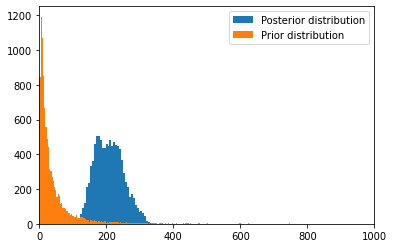

In [128]:
plt.hist(chain, label = "Posterior distribution",bins = "auto")
plt.hist(priors, label = "Prior distribution",bins = "auto")
plt.legend(loc = 'upper right')
plt.xlim(0,1000)